# IMAGINE tutorial 5 -- an almost real IMAGINE pipeline

### (Using the WMAP model for the field and the hammurabi simulator.)


First, import the necessary packages.  The comments indicate which of teh elements in the above figure these correspond to:

In [1]:
import numpy as np
import logging as log
import healpy as hp

## Classes that store Observables (simulated or measured) and covariance matrices
from imagine.observables.observable_dict import Simulations, Measurements, Covariances
## The likelihood class (obviously the Likelihood element)
from imagine.likelihoods.ensemble_likelihood import EnsembleLikelihood

## The WMAP field and its factory (one possibilty for the Galaxy-Generator element)
from imagine.fields.breg_wmap.hamx_field import BregWMAP
from imagine.fields.breg_wmap.hamx_factory import BregWMAPFactory
## The random field component
from imagine.fields.brnd_es.hamx_field import BrndES
from imagine.fields.brnd_es.hamx_factory import BrndESFactory
## The simple analytic CRE model
from imagine.fields.cre_analytic.hamx_field import CREAna
from imagine.fields.cre_analytic.hamx_factory import CREAnaFactory
## The YMW16 thermal (free) electron model:
from imagine.fields.fereg_ymw16.hamx_field import FEregYMW16
from imagine.fields.fereg_ymw16.hamx_factory import FEregYMW16Factory


## A flat prior
from imagine.priors.flat_prior import FlatPrior
## The toy model simulator (one possibility for the Observable-Generator element)
from imagine.simulators.hammurabi.hammurabi import Hammurabi 
## The pyMultiNest sampler (one possibility for the Sampler element)
from imagine.pipelines.multinest_pipeline import MultinestPipeline
from imagine.pipelines.dynesty_pipeline import DynestyPipeline
## A tool to estimate a covariance matrix from an ensemble of stochastic simulations:
from imagine.tools.covariance_estimator import oas_cov

## visualize posterior with 3rd party corner package (pip install corner)
import corner
import matplotlib
## Mapping internal parameter units to physical units
from imagine.tools.carrier_mapper import unity_mapper
matplotlib.use('Agg')

# call after importing matplotlib
%matplotlib inline

## step 1, mock data preparation

Let's make a very low resolution map of synchrotron total I and Faraday depth from the WMAP model, including a random compnent:

In [2]:
## Set the resolution
nside=2
npix=12*nside**2
## All of the other hammurabi parameters are in here, set up for
##  both a regular and low-res random grid:
xmlpath = './params_hammurabi_regRand.xml'
    
## An empty measurement set to define what we want:
trigger = Measurements()
trigger.append(('sync', '23', str(nside), 'I'), np.zeros((1,npix)))  # only I map
trigger.append(('fd', 'nan', str(nside), 'nan'), np.zeros((1,npix)))  # only I map

## This instance of hammurabi is to mock up some fake data:
mocker = Hammurabi(measurements=trigger, xml_path=xmlpath)


observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '2'}
|-->  faraday {'cue': '1', 'nside': '2'}


Select the models we want to use:

In [3]:
# BregWMAP field
paramlist={'b0':3, 'psi0': 27.0, 'psi1': 0.9, 'chi0': 25.0}
breg_wmap = BregWMAP(paramlist, 1)

# CREAna field
paramlist = {'alpha': 3.0, 'beta': 0.0, 'theta': 0.0,
             'r0': 5.0, 'z0': 1.0,
             'E0': 20.6, 'j0': 0.0217}  # inactive parameters at default
cre_ana = CREAna(paramlist, 1)

# FEregYMW16 field
paramlist = dict() 
fereg_ymw16 = FEregYMW16(paramlist, 1)

## Random field
paramlist = {'rms': 3., 'k0': 0.5, 'a0': 1.7, 'rho': 0.5, 'r0': 8., 'z0': 1.}
brnd_es = BrndES(paramlist, 1)


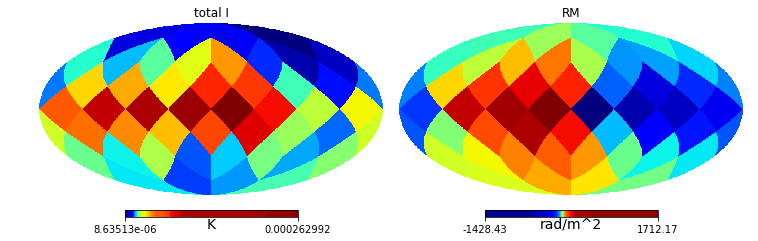

In [4]:
## Generate mock data (run hammurabi)
outputs = mocker([breg_wmap, brnd_es, cre_ana, fereg_ymw16])
## Collect the outputs
mockedI = outputs[('sync', '23', str(nside), 'I')].to_global_data()
mockedRM = outputs[('fd', 'nan', str(nside), 'nan')].to_global_data()
dm=np.mean(mockedI)
dv=np.std(mockedI)
## Add some noise that's just proportional to the average sync I by the factor err
err=0.01
dataI = np.vstack([mockedI + np.random.normal(loc=0.,scale=err*dm,size=12*nside**2)])
## Just 0.01*50 rad/m^2 of error for noise.  
dataRM = np.vstack([mockedRM + np.random.normal(loc=0.,scale=err*50.,size=12*nside**2)])

mock_data = Measurements()
mock_data.append(('sync', '23', str(nside), 'I'), dataI)
mock_data.append(('fd', 'nan', str(nside), 'nan'), dataRM)

## Diagonal covariances that only include the noise
mock_cov = Covariances()
mock_cov.append(('sync', '23', str(nside), 'I'), ((err*dm)**2) * np.eye(12*nside**2) )
mock_cov.append(('fd', 'nan', str(nside), 'nan'), ((err*50.)**2) * np.eye(12*nside**2) )

## Get the data back out in a plottable format, ie. undo the vstack with an hstack
matplotlib.rcParams['figure.figsize'] = (10.0, 4.0)
hp.mollview(np.hstack(dataI), norm='hist', cmap='jet',sub=(1,2,1),title="total I",unit='K')
hp.mollview(np.hstack(dataRM), norm='hist', cmap='jet',sub=(1,2,2),title="RM",unit='rad/m^2')

Now let's set up the pipeline as we have done before, but this time with hammurabi as the simulator:

In [5]:
## Use an ensemble to estimate the galactic variance
likelihood = EnsembleLikelihood(mock_data, mock_cov)

## WMAP B-field, vary only b0 and psi0
breg_factory = BregWMAPFactory(active_parameters=('b0', 'psi0'))
breg_factory.parameter_ranges = {'b0': (0., 10.), 'psi0': (0., 50.)}
## Random B-field, vary only RMS amplitude
brnd_factory = BrndESFactory(active_parameters=('rms',))
brnd_factory.parameter_ranges = {'rms': (0., 10.)}
## Fixed CR model
cre_factory = CREAnaFactory()
## Fixed FE model
fereg_factory = FEregYMW16Factory()
factory_list = [breg_factory, brnd_factory, cre_factory, fereg_factory]

## Flat prior
prior = FlatPrior()
## Hammurabi simulator
simer = Hammurabi(measurements=mock_data, xml_path=xmlpath)

## Compute 10 realizations at each sample:
ensemble_size=10

## Initialize the pipeline with all of these inputs
#pipe = MultinestPipeline(simer, factory_list, likelihood, prior, ensemble_size)
pipe = DynestyPipeline(simer, factory_list, likelihood, prior, ensemble_size)


observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '2'}
|-->  faraday {'cue': '1', 'nside': '2'}


This run will take a long time to converge.  

In [ ]:
## Verbose logging prints every sample, so this ends up large.
##  But it's useful to watch it run.  
## NO, this doesn't work in Jupyter, sadly.  
#log.basicConfig(filename='./imagine.log', level=log.DEBUG)

pipe.sampling_controllers = {'nlive': 400} # mind the difference here

## And run it
results=pipe()